# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Final Project/2 Ethereum.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
1,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
3,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
4,2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000


In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1979 non-null   object 
 1   Open       1979 non-null   float64
 2   High       1979 non-null   float64
 3   Low        1979 non-null   float64
 4   Close      1979 non-null   float64
 5   Adj Close  1979 non-null   float64
 6   Volume     1979 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.4+ KB


In [ ]:
# Verify that the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering: Logarithmic Return, Moving averages, Volatility
df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) # For handling non-stationarity
df['MA 20'] = df['Adj Close'].rolling(window=20).mean()
df['Volatility'] = df['Adj Close'].rolling(window=20).std()

# Lagged Features
for lag in range(1, 6):
    df[f'Lag {lag}'] = df['Close'].shift(lag)

df['Volatility_MA20'] = df['Volatility'] * df['MA 20']

# Market State Classification
def classify_market_state(row):
    if row['Volatility'] < 0.02:
        return 'Low Volatility'
    elif row['Volatility'] < 0.05:
        return 'Medium Volatility'
    else:
        return 'High Volatility'

df['Market State'] = df.apply(classify_market_state, axis=1)

# drop unnecessary/abnormal columns
df.drop(columns=['Adj Close'], inplace=True)
df.dropna(inplace=True)

# deep reinforcement learning is sensitive to number range, so we normalize the data
# Sliding window normalization
def normalize_dynamic_window(data, features, window_size=50):
  normalized_data = data.copy()
  for feature in features:
    normalized_column = f"{feature}_scaled"
    normalized_data[normalized_column] = (
        normalized_data[feature].rolling(window=window_size, min_periods=1).apply(lambda x: ((x.iloc[-1] - x.mean()) / (x.std() + 1e-8))
        if x.std() > 0 else np.nan, raw=False).clip(-3, 3)
        )
  return normalized_data

features_to_normalize = ['Log Return', 'MA 20', 'Volatility']
df = normalize_dynamic_window(df, features=features_to_normalize, window_size=50)

# Define in-sample(2018-2020) and out-of-sample(2021-2022) periods
in_sample = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2020-12-31')]
out_sample = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2022-12-31')]
in_sample.reset_index(drop=True, inplace=True)
out_sample.reset_index(drop=True, inplace=True)

In [ ]:
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Log Return,MA 20,Volatility,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volatility_MA20,Market State,Log Return_scaled,MA 20_scaled,Volatility_scaled
20,2017-11-30,431.214996,465.497009,401.243011,447.114014,1903040000,0.044806,386.698453,62.681287,427.523010,472.902008,480.355011,471.329987,466.276001,24238.756749,High Volatility,0.707107,0.707107,-0.707107
21,2017-12-01,445.209015,472.609009,428.312012,466.540009,1247879936,0.042530,394.291403,62.696023,447.114014,427.523010,472.902008,480.355011,471.329987,24720.502772,High Volatility,0.563666,1.004417,-0.566684
22,2017-12-02,466.851013,476.239014,456.653015,463.449005,943649984,-0.006647,402.068454,61.041859,466.540009,447.114014,427.523010,472.902008,480.355011,24543.006047,High Volatility,-0.023468,1.171539,-1.312777
23,2017-12-03,463.704987,482.813995,451.851990,465.852997,990556992,0.005174,409.525304,59.146294,463.449005,466.540009,447.114014,427.523010,472.902008,24221.904110,High Volatility,0.138129,1.263664,-1.492954
24,2017-12-04,466.053986,474.777008,453.312012,470.204010,1005550016,0.009297,416.153954,58.084210,465.852997,463.449005,466.540009,447.114014,427.523010,24171.973817,High Volatility,0.192713,1.302919,-1.402111


## Data Visualization

In [ ]:
print("In-sample size:", in_sample.shape)
print("Out-of-sample size:", out_sample.shape)

In-sample size: (1096, 19)
Out-of-sample size: (730, 19)


In [ ]:
print(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Log Return', 'MA 20', 'Volatility']].describe())
# should be between 0~1 due to normalization

              Open         High          Low        Close        Volume  \
count  1959.000000  1959.000000  1959.000000  1959.000000  1.959000e+03   
mean   1162.594046  1199.035008  1121.674108  1163.113214  1.278863e+10   
std    1166.625900  1201.989901  1126.044447  1166.162301  1.056553e+10   
min      84.279694    85.342743    82.829887    84.308296  9.436500e+08   
25%     215.771232   221.400665   208.997757   215.969932  5.069084e+09   
50%     603.902039   618.983154   580.628784   605.187012  1.035859e+10   
75%    1775.351074  1817.918396  1710.958801  1775.297363  1.788867e+10   
max    4810.071289  4891.704590  4718.039063  4812.087402  8.448291e+10   

        Log Return        MA 20   Volatility  
count  1959.000000  1959.000000  1959.000000  
mean      0.000762  1156.148598    94.967116  
std       0.050420  1157.929740   107.345435  
min      -0.550732    97.268186     2.494690  
25%      -0.021279   215.872735    15.331580  
50%       0.000806   595.053110    47.7834

In [ ]:
df.to_csv("/content/drive/MyDrive/Final Project/Normalized Ethereum.csv", index=False)


df_loaded = pd.read_csv("/content/drive/MyDrive/Final Project/Normalized Ethereum.csv")
print(df_loaded.head())

         Date        Open        High         Low       Close      Volume  \
0  2017-11-30  431.214996  465.497009  401.243011  447.114014  1903040000   
1  2017-12-01  445.209015  472.609009  428.312012  466.540009  1247879936   
2  2017-12-02  466.851013  476.239014  456.653015  463.449005   943649984   
3  2017-12-03  463.704987  482.813995  451.851990  465.852997   990556992   
4  2017-12-04  466.053986  474.777008  453.312012  470.204010  1005550016   

   Log Return       MA 20  Volatility       Lag 1       Lag 2       Lag 3  \
0    0.044806  386.698453   62.681287  427.523010  472.902008  480.355011   
1    0.042530  394.291403   62.696023  447.114014  427.523010  472.902008   
2   -0.006647  402.068454   61.041859  466.540009  447.114014  427.523010   
3    0.005174  409.525304   59.146294  463.449005  466.540009  447.114014   
4    0.009297  416.153954   58.084210  465.852997  463.449005  466.540009   

        Lag 4       Lag 5  Volatility_MA20     Market State  \
0  471.3299

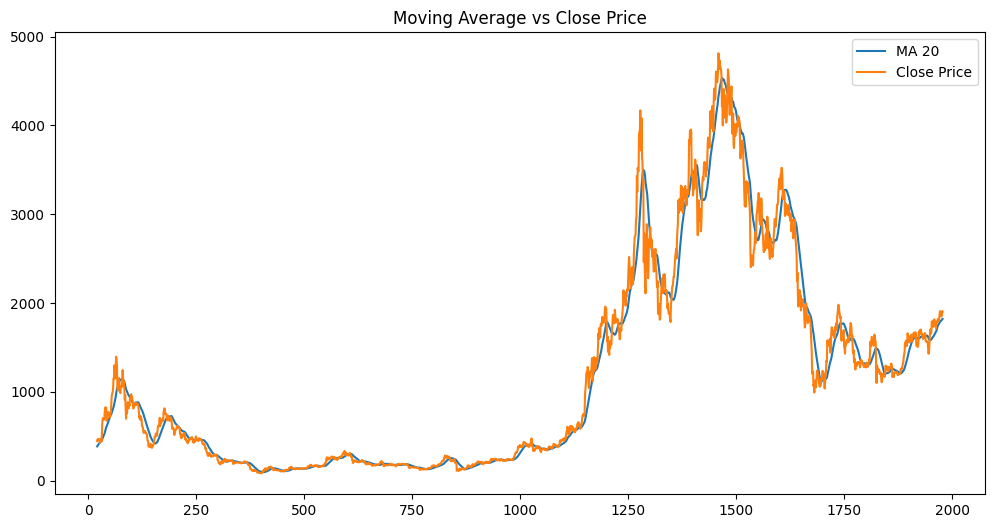

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['MA 20'], label='MA 20')
plt.plot(df['Close'], label='Close Price')
plt.legend()
plt.title('Moving Average vs Close Price')
plt.show()

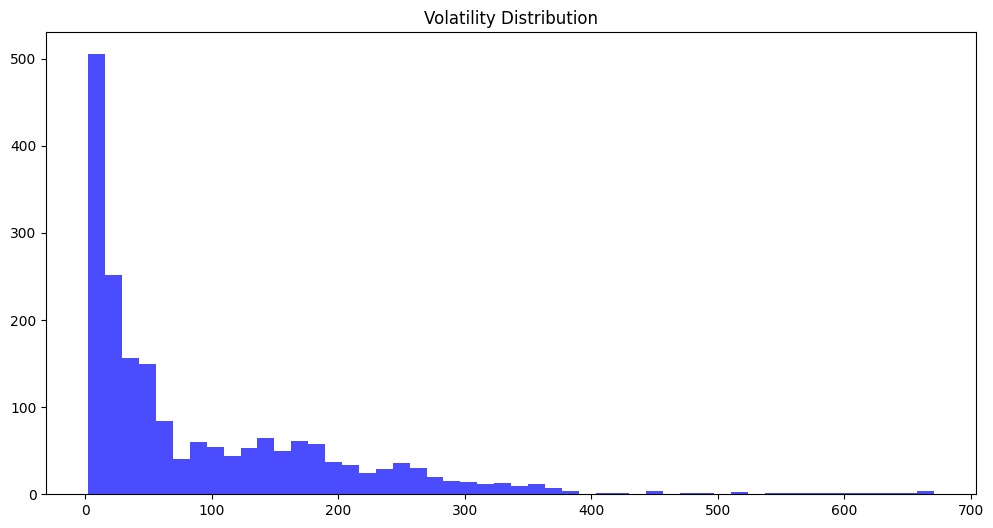

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df['Volatility'], bins=50, color='blue', alpha=0.7)
plt.title('Volatility Distribution')
plt.show()

# Environment

In [ ]:
states = ["Low Volatility", "Medium Volatility", "High Volatility"]

action_mapping = {0: "Hold", 1: "Buy", 2: "Sell"}
actions = list(action_mapping.keys())

In [ ]:
def initialize_env(data, initial_balance=10000, transaction_cost=0.001):
    env = {
        'data': data.reset_index(drop=True),
        'n_steps': len(data),
        'initial_balance': initial_balance,
        'transaction_cost': transaction_cost,
        'current_step': 0,
        'balance': initial_balance,
        'holdings': 0,
        'total_value': initial_balance,
        'total_values': [initial_balance],  # Track total values over time
        'returns': [],  # Portfolio returns
        'sharpe_ratios': [],  # Sharpe Ratios
        'done': False
    }
    return env

def reset_env(env):
    env['current_step'] = 0
    env['balance'] = env['initial_balance']
    env['holdings'] = 0
    env['total_value'] = env['initial_balance']
    env['total_values'] = [env['initial_balance']]  # Reset total values
    env['returns'] = []
    env['sharpe_ratios'] = []  # Reset Sharpe Ratios
    env['done'] = False
    return get_observation(env)

def get_observation(env):
    # Select only the scaled columns as features
    numeric_columns = env['data'][['Log Return_scaled', 'MA 20_scaled', 'Volatility_scaled']]
    return numeric_columns.iloc[env['current_step']].values

def render_env(env):
    if len(env['returns']) > 1:
        mean_return = np.mean(env['returns'])  # Cumulative mean return
        volatility = np.std(env['returns']) + 1e-9  # Cumulative volatility
        sharpe_ratio = mean_return / volatility if volatility > 0 else 0
    else:
        sharpe_ratio = 0  # Default Sharpe Ratio

    print(f"Step: {env['current_step']}, Balance: {env['balance']:.2f}, "
          f"Holdings: {env['holdings']:.2f}, Total Value: {env['total_value']:.2f}, "
          f"Sharpe Ratio: {sharpe_ratio:.4f}")

def step_env(env, action):
    # Get current price
    current_price = env['data'].iloc[env['current_step']]['Close']
    previous_value = env['total_value']

    # Take actions: Buy, Sell, or Hold
    if action == 1:  # Buy
        if env['balance'] > 0:
            env['holdings'] += (env['balance'] * (1 - env['transaction_cost'])) / current_price
            env['balance'] = 0
    elif action == 2:  # Sell
        if env['holdings'] > 0:
            env['balance'] += env['holdings'] * current_price * (1 - env['transaction_cost'])
            env['holdings'] = 0

    # Update portfolio value
    env['total_value'] = env['balance'] + env['holdings'] * current_price
    env['total_values'].append(env['total_value'])  # Track total value over time

    # Calculate portfolio return
    portfolio_return = ((env['total_value'] - previous_value)/ previous_value)*100 if previous_value > 0 else 0
    env['returns'].append(portfolio_return)

    # Calculate cumulative Sharpe Ratio
    if len(env['returns']) > 1:
        mean_return = np.mean(env['returns'])
        volatility = np.std(env['returns']) + 1e-9
        sharpe_ratio = mean_return / volatility if volatility > 0 else 0
    else:
        sharpe_ratio = 0

    env['sharpe_ratios'].append(sharpe_ratio)

    # Advance step
    env['current_step'] += 1
    env['done'] = env['current_step'] >= env['n_steps'] - 1

    # Return observation, portfolio reward, sharpe reward, done, and info
    return get_observation(env), portfolio_return, sharpe_ratio, env['done'], {
        "sharpe_ratio": sharpe_ratio,
        "total_value": env['total_value']
    }

def normalize(value, min_val, max_val):
    # Avoid division by zero by ensuring max_val > min_val
    if max_val == min_val:
        return 0  # Neutral value if no variation
    return (value - min_val) / (max_val - min_val) * 2 - 1


In [ ]:
import random
# Test Script: Run One Episode
# Initialize the environment with the given data
env = initialize_env(df, initial_balance=10000, transaction_cost=0.001)

# Reset the environment and get the initial state
state = reset_env(env)

print("Starting one episode...\n")

# Run one episode
while not env['done']:
    # Random action: 0 = Hold, 1 = Buy, 2 = Sell
    action = random.choice([0, 1, 2])

    # Take the step and retrieve metrics
    next_state, portfolio_return, sharpe_reward, done, info = step_env(env, action)

    # Print step-by-step metrics
    print(f"Step: {env['current_step']}, Action: {['Hold', 'Buy', 'Sell'][action]}, "
          f"Sharpe Ratio: {info['sharpe_ratio']:.4f}, "
          f"Total Value: {info['total_value']:.2f}")

    # Update state
    state = next_state

print("\nEpisode finished.")
print(f"Final Total Value: {env['total_value']:.2f}")


Starting one episode...

Step: 1, Action: Buy, Sharpe Ratio: 0.0000, Total Value: 9990.00
Step: 2, Action: Buy, Sharpe Ratio: 0.9550, Total Value: 10424.04
Step: 3, Action: Sell, Sharpe Ratio: 0.5120, Total Value: 10344.62
Step: 4, Action: Sell, Sharpe Ratio: 0.4296, Total Value: 10344.62
Step: 5, Action: Hold, Sharpe Ratio: 0.3773, Total Value: 10344.62
Step: 6, Action: Hold, Sharpe Ratio: 0.3404, Total Value: 10344.62
Step: 7, Action: Hold, Sharpe Ratio: 0.3126, Total Value: 10344.62
Step: 8, Action: Hold, Sharpe Ratio: 0.2906, Total Value: 10344.62
Step: 9, Action: Sell, Sharpe Ratio: 0.2727, Total Value: 10344.62
Step: 10, Action: Buy, Sharpe Ratio: 0.2498, Total Value: 10334.28
Step: 11, Action: Buy, Sharpe Ratio: -0.1259, Total Value: 9640.65
Step: 12, Action: Sell, Sharpe Ratio: 0.2118, Total Value: 11231.70
Step: 13, Action: Buy, Sharpe Ratio: 0.2015, Total Value: 11220.47
Step: 14, Action: Sell, Sharpe Ratio: 0.2911, Total Value: 12092.60
Step: 15, Action: Sell, Sharpe Ratio: 

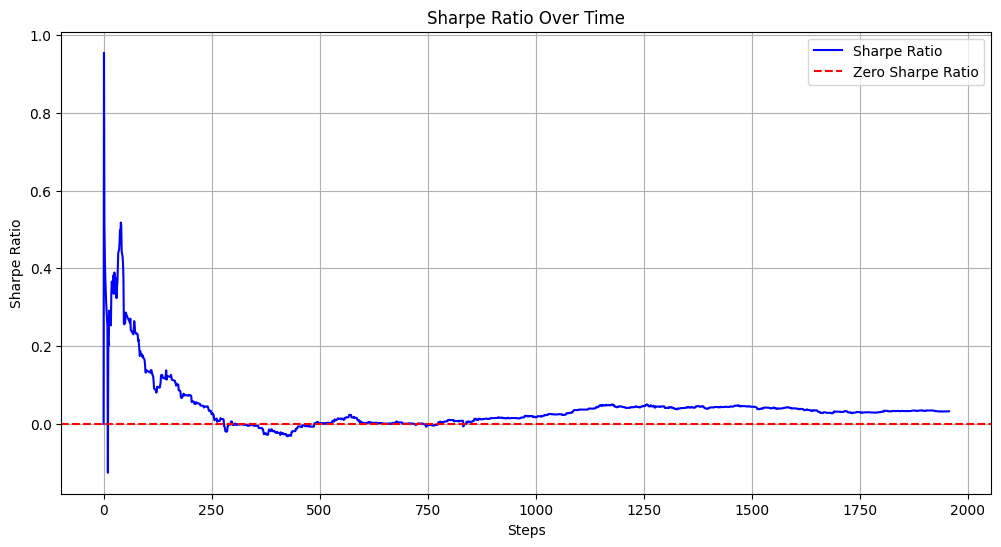

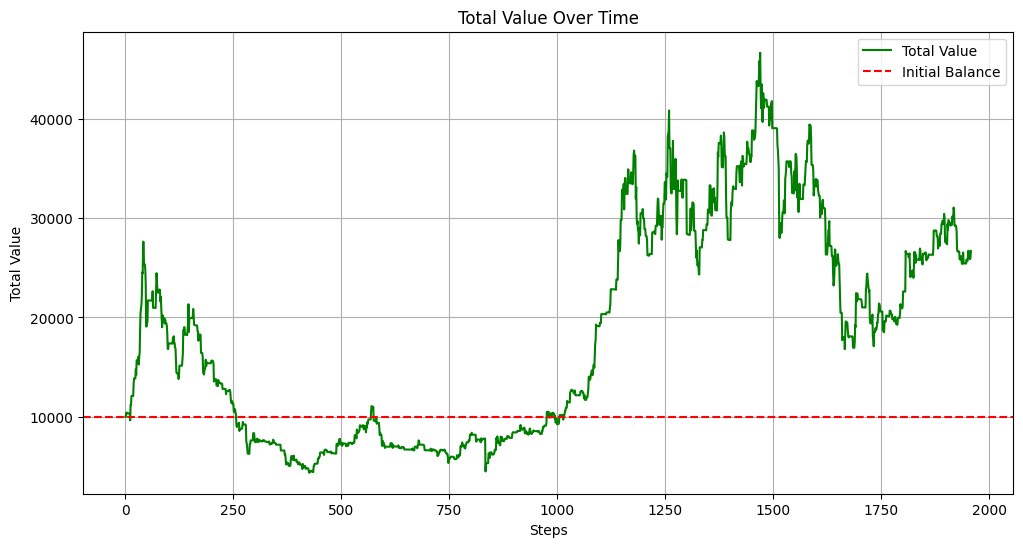

In [ ]:
# Visualize the Sharpe Ratio
sharpe_ratios = env['sharpe_ratios']
plt.figure(figsize=(12, 6))
plt.plot(sharpe_ratios, label='Sharpe Ratio', color='blue')
plt.title('Sharpe Ratio Over Time')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='red', linestyle='--', label='Zero Sharpe Ratio')
plt.legend()
plt.grid()
plt.show()

# Visualize the Total Value
plt.figure(figsize=(12, 6))
plt.plot(env['total_values'], label='Total Value', color='green')
plt.title('Total Value Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Value')
plt.axhline(env['initial_balance'], color='red', linestyle='--', label='Initial Balance')  # Baseline
plt.legend()
plt.grid()
plt.show()

# Deep Q-Learning

## Focus only on Sharpe, no normalization

In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Build DQN Model
def build_dqn_model(state_size, action_size):
    model = models.Sequential([
        layers.Input(shape=(state_size,)),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
# Training
state_size = 3  # Log Return_scaled, MA 20_scaled, Volatility_scaled
action_size = 3  # Actions: [Hold, Buy, Sell]
dqn_model = build_dqn_model(state_size, action_size)
replay_buffer = deque(maxlen=2000)
initial_epsilon = 0.5
final_epsilon = 0.01
epsilon_decay = 0.99
discount_factor = 0.95
batch_size = 32
num_episodes = 10
max_steps = 500
step_patience = 100  # Step-level early stopping patience

losses = []
episode_sharpe_ratios = []
episode_return_rewards = []
average_q_values = []

# Early stopping parameters
patience = 5  # Episode-level early stopping patience
best_sharpe = -np.inf  # Initialize as negative infinity
early_stop_counter = 0

# Track the best model
best_sharpe_episode = -1
best_step_sharpe = -np.inf

for episode in range(num_episodes):
    env = initialize_env(in_sample)
    state = get_observation(env)
    returns = []  # To track returns for Sharpe ratio calculation
    q_values_sum = 0
    steps = 0
    epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))

    # Step-level early stopping variables
    best_step_reward = -np.inf
    no_improvement_steps = 0

    while not env["done"] and steps < max_steps:
        # Epsilon-Greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice([0, 1, 2])
        else:
            q_values = dqn_model.predict(np.array(state).reshape(1, -1), verbose=0)
            action = np.argmax(q_values[0])
            q_values_sum += np.max(q_values[0])

        # Step in the environment
        next_state, portfolio_reward, _, done, _ = step_env(env, action)
        returns.append(portfolio_reward)  # Append the portfolio reward to calculate Sharpe ratio
        replay_buffer.append((state, action, portfolio_reward, next_state, done))
        state = next_state

        # Train DQN model using replay buffer
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = np.array(states)
            next_states = np.array(next_states)
            target_qs = dqn_model.predict(states, verbose=0)
            next_qs = dqn_model.predict(next_states, verbose=0)

            for i in range(batch_size):
                if dones[i]:
                    target_qs[i][actions[i]] = rewards[i]
                else:
                    target_qs[i][actions[i]] = rewards[i] + discount_factor * np.max(next_qs[i])

            history = dqn_model.fit(states, target_qs, verbose=0, epochs=1)
            losses.append(history.history['loss'][0])

        # Calculate step-level Sharpe ratio
        step_mean_return = np.mean(returns) if returns else 0
        step_std_dev_return = np.std(returns) + 1e-9  # Avoid division by zero
        step_sharpe_ratio = step_mean_return / step_std_dev_return if step_std_dev_return > 0 else 0

        # Save step-level best model
        if step_sharpe_ratio > best_step_sharpe:
            best_step_sharpe = step_sharpe_ratio
            dqn_model.save('/content/drive/MyDrive/Final Project/DeepQ_model_step_best.keras')
            print(f"Step-level best model saved at Episode {episode + 1} with Step Sharpe Ratio: {best_step_sharpe:.4f}")
            no_improvement_steps = 0
        else:
            no_improvement_steps += 1

        # Step-level early stopping
        if no_improvement_steps >= step_patience:
            print(f"Step-level early stopping triggered at step {steps + 1} in episode {episode + 1}")
            break

        steps += 1

    # Calculate episode-level Sharpe ratio
    mean_return = np.mean(returns) if returns else 0
    std_dev_return = np.std(returns) + 1e-9  # Avoid division by zero
    episode_sharpe_ratio = mean_return / std_dev_return if std_dev_return > 0 else 0

    # Save episode metrics
    average_q_values.append(q_values_sum / steps if steps > 0 else 0)
    episode_sharpe_ratios.append(episode_sharpe_ratio)
    episode_return_rewards.append(np.sum(returns))

    # Save the best model based on episode-level Sharpe ratio
    if episode_sharpe_ratio > best_sharpe:
        best_sharpe = episode_sharpe_ratio
        best_sharpe_episode = episode + 1
        dqn_model.save('/content/drive/MyDrive/Final Project/DeepQ_model_episode_best.keras')
        print(f"Episode-level best model saved at Episode {best_sharpe_episode} with Sharpe Ratio: {best_sharpe:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Episode-level early stopping triggered at episode {episode + 1}")
            break

    print(f"Episode {episode + 1}/{num_episodes}, Sharpe Ratio: {episode_sharpe_ratio:.4f}, "
          f"Return Reward: {np.sum(returns):.2f}%%, Avg Q-Value: {average_q_values[-1]:.2f}, Steps: {steps}")

print(f"Training Complete. Best Sharpe Ratio: {best_sharpe:.4f} achieved in Episode {best_sharpe_episode}")


Step-level best model saved at Episode 1 with Step Sharpe Ratio: 0.0000
Step-level best model saved at Episode 1 with Step Sharpe Ratio: 0.6952
Step-level best model saved at Episode 1 with Step Sharpe Ratio: 0.7267
Step-level best model saved at Episode 1 with Step Sharpe Ratio: 0.7496
Step-level best model saved at Episode 1 with Step Sharpe Ratio: 0.8997
Step-level early stopping triggered at step 106 in episode 1
Episode-level best model saved at Episode 1 with Sharpe Ratio: -0.0406
Episode 1/10, Sharpe Ratio: -0.0406, Return Reward: -21.47%%, Avg Q-Value: 1.64, Steps: 105
Step-level early stopping triggered at step 100 in episode 2
Episode-level best model saved at Episode 2 with Sharpe Ratio: 0.1214
Episode 2/10, Sharpe Ratio: 0.1214, Return Reward: 48.25%%, Avg Q-Value: 13.25, Steps: 99
Step-level early stopping triggered at step 100 in episode 3
Episode 3/10, Sharpe Ratio: 0.0102, Return Reward: 4.80%%, Avg Q-Value: 14.30, Steps: 99
Step-level early stopping triggered at step 1

In [ ]:
# Testing

# Load the best saved model (episode-level best)
best_model_path = '/content/drive/MyDrive/Final Project/DeepQ_model_episode_best.keras'  # Change this to the correct path
dqn_model = tf.keras.models.load_model(best_model_path)

test_env = initialize_env(out_sample)  # Use the last 20% of the data for testing
test_state = get_observation(test_env)
test_returns = []  # To track percentage returns for Sharpe ratio calculation
test_steps = 0

while not test_env["done"]:
    # Predict action
    q_values = dqn_model.predict(np.array(test_state).reshape(1, -1), verbose=0)
    test_action = np.argmax(q_values[0])  # Choose the best action

    # Take a step in the test environment
    next_state, portfolio_return, sharpe_reward, done, _ = step_env(test_env, test_action)
    test_returns.append(portfolio_return)  # Append the portfolio return (percentage) to calculate Sharpe ratio
    test_state = next_state
    test_steps += 1

# Calculate Sharpe Ratio for testing
test_mean_return = np.mean(test_returns) if test_returns else 0
test_std_dev_return = np.std(test_returns) + 1e-9  # Avoid division by zero
test_sharpe_ratio = test_mean_return / test_std_dev_return if test_std_dev_return > 0 else 0

# Calculate the return percentage correctly using initial balance and final portfolio value
final_portfolio_value = test_env['total_value']  # Final portfolio value
initial_balance = test_env['initial_balance']  # Initial balance
test_return_percentage = ((final_portfolio_value - initial_balance) / initial_balance) * 100

# Print Test Results
print(f"Testing Complete: Sharpe Ratio: {test_sharpe_ratio:.4f}, "
      f"Total Return Reward: {test_return_percentage:.2f}%, Steps: {test_steps}")


Testing Complete: Sharpe Ratio: 0.0555, Total Return Reward: 180.47%, Steps: 729


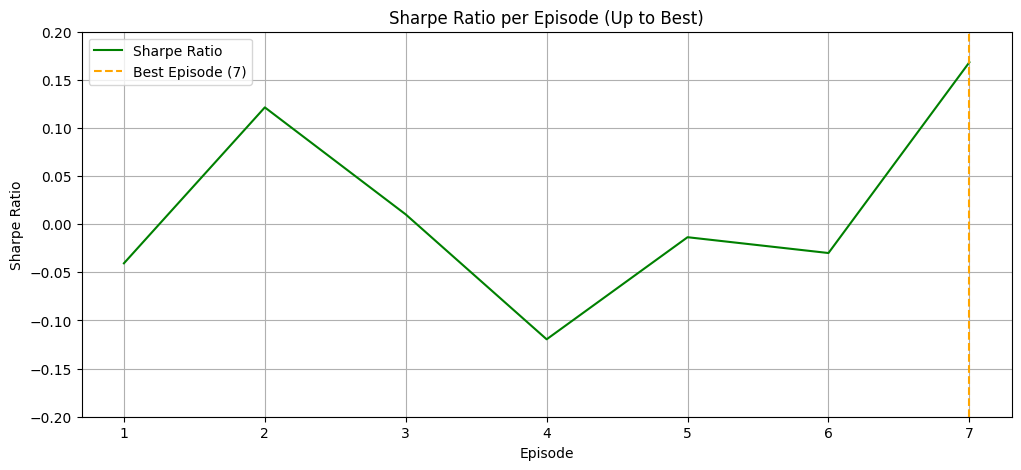

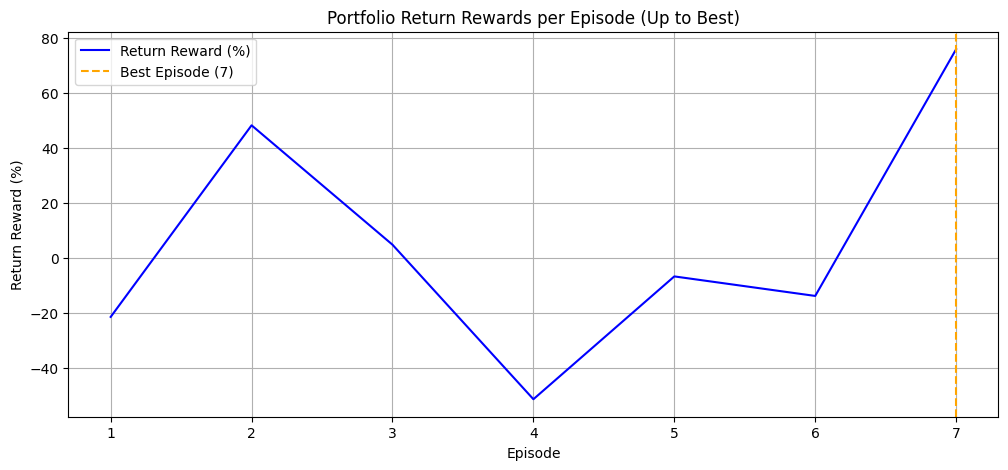

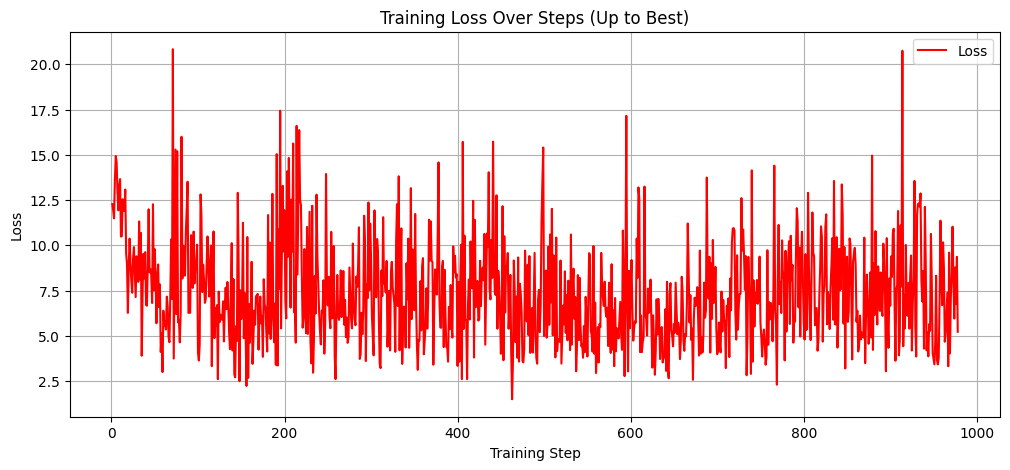

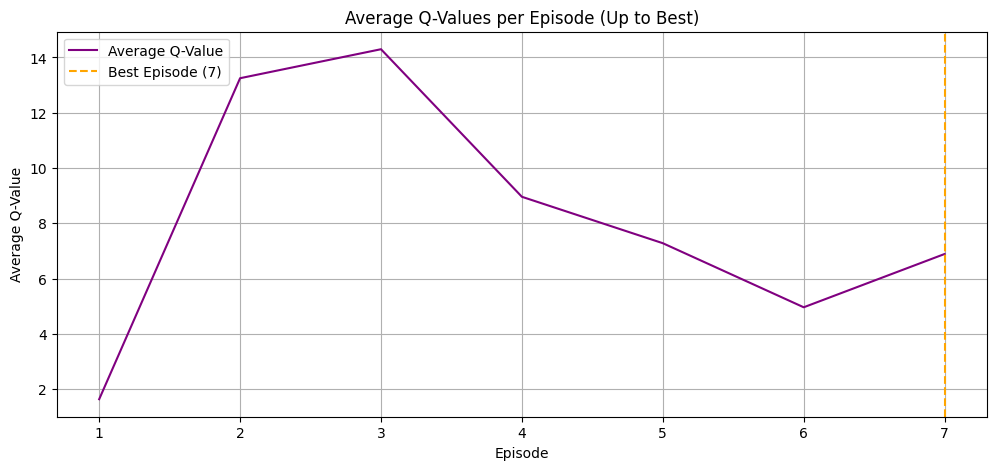

Testing Complete: Sharpe Ratio: 0.0555, Total Return Reward: 180.47%, Steps: 729


In [ ]:
# Plot Sharpe Ratio per Episode
plt.figure(figsize=(12, 5))
plt.plot(range(1, best_sharpe_episode + 1), episode_sharpe_ratios[:best_sharpe_episode],
         label="Sharpe Ratio", color="green")
plt.axvline(best_sharpe_episode, color="orange", linestyle="--",
            label=f"Best Episode ({best_sharpe_episode})")
plt.title("Sharpe Ratio per Episode (Up to Best)")
plt.xlabel("Episode")
plt.ylabel("Sharpe Ratio")
plt.ylim(-0.2, 0.2)  # Adjust y-axis limits for better visualization
plt.legend()
plt.grid(True)
plt.show()

# Return Rewards per Episode
plt.figure(figsize=(12, 5))
plt.plot(range(1, best_sharpe_episode + 1), episode_return_rewards[:best_sharpe_episode],
         label="Return Reward (%)", color="blue")
plt.axvline(best_sharpe_episode, color="orange", linestyle="--",
            label=f"Best Episode ({best_sharpe_episode})")
plt.title("Portfolio Return Rewards per Episode (Up to Best)")
plt.xlabel("Episode")
plt.ylabel("Return Reward (%)")
plt.legend()
plt.grid(True)
plt.show()

# Loss over training steps (Optional: depends on how steps map to episodes)
if len(losses) > 0:
    best_step = min(len(losses), best_sharpe_episode * max_steps)  # Ensure it doesn't exceed total steps
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, best_step + 1), losses[:best_step], label="Loss", color="red")
    plt.title("Training Loss Over Steps (Up to Best)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Average Q-Values per Episode
plt.figure(figsize=(12, 5))
plt.plot(range(1, best_sharpe_episode + 1), average_q_values[:best_sharpe_episode],
         label="Average Q-Value", color="purple")
plt.axvline(best_sharpe_episode, color="orange", linestyle="--",
            label=f"Best Episode ({best_sharpe_episode})")
plt.title("Average Q-Values per Episode (Up to Best)")
plt.xlabel("Episode")
plt.ylabel("Average Q-Value")
plt.legend()
plt.grid(True)
plt.show()

# Print Test Results
print(f"Testing Complete: Sharpe Ratio: {test_sharpe_ratio:.4f}, "
      f"Total Return Reward: {test_return_percentage:.2f}%, Steps: {test_steps}")



Sharpe Ratios for Each State:
State: Low Volatility, Sharpe Ratios: {'Buy': 1.489695741437282, 'Hold': 0.8088272938655336, 'Sell': -1.7473876884697108}
State: Medium Volatility, Sharpe Ratios: {'Buy': -0.14839633022080045, 'Hold': -0.2562808256969702, 'Sell': -1.2655062934217343}
State: High Volatility, Sharpe Ratios: {'Buy': 1.8227892712146967, 'Hold': -0.06738906604777695, 'Sell': -1.3403060731047245}

Portfolio Values for Each State:
State: Low Volatility, Portfolio Values: {'Buy': 91742.12534760415, 'Hold': 110184.00395637697, 'Sell': 90635.69937323678}
State: Medium Volatility, Portfolio Values: {'Buy': 85537.88630179012, 'Hold': 100585.82298024495, 'Sell': 111263.0658910152}
State: High Volatility, Portfolio Values: {'Buy': 92651.71729596725, 'Hold': 81498.09359382265, 'Sell': 83587.12139683019}

Q-Values for Each State:
State: Low Volatility, Q-Values: {'Buy': 6.1514397, 'Hold': 4.6192126, 'Sell': 4.9555507}
State: Medium Volatility, Q-Values: {'Buy': 19.005865, 'Hold': 22.5020

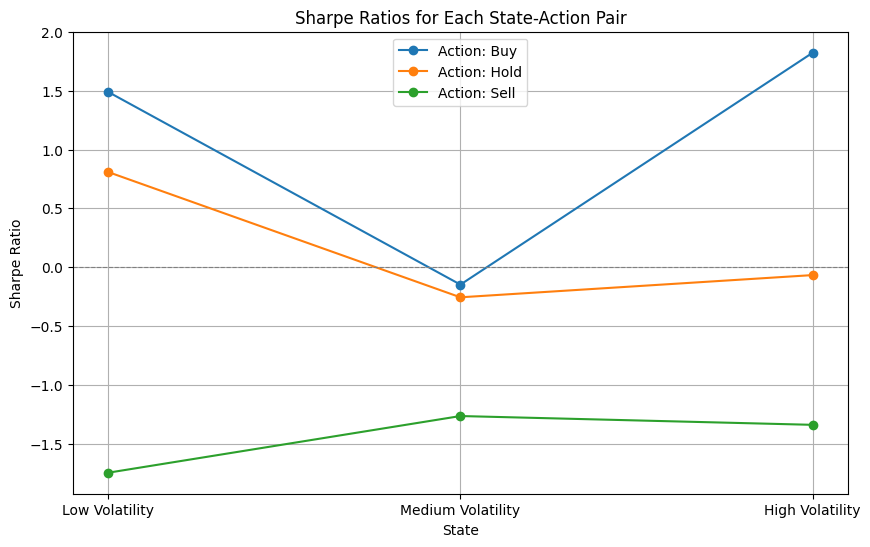

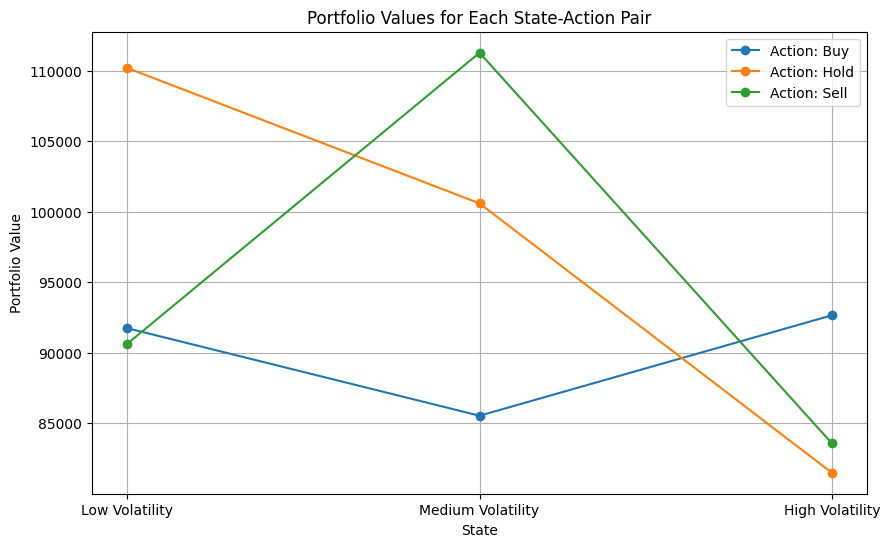

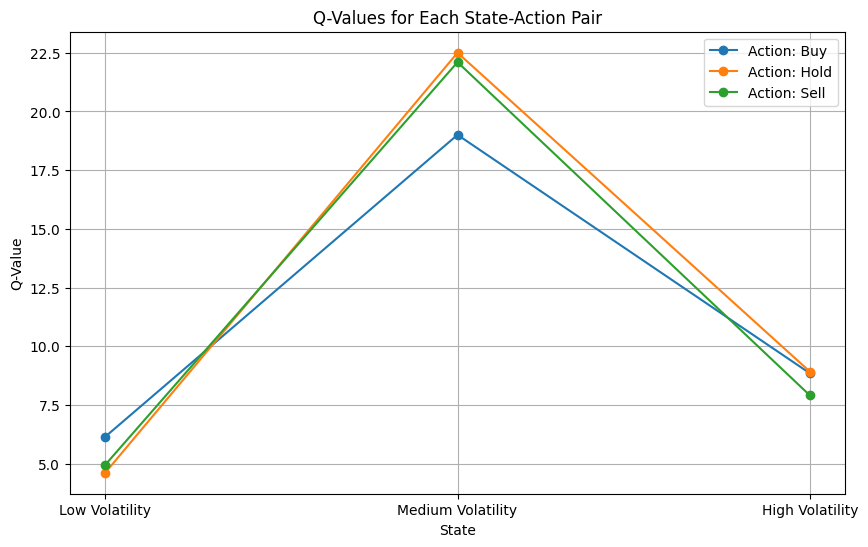

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the states and actions
states = ["Low Volatility", "Medium Volatility", "High Volatility"]
actions = ["Buy", "Hold", "Sell"]

# One-hot encoding for states
state_encoding = {state: np.eye(len(states))[i] for i, state in enumerate(states)}
state_size = len(state_encoding[states[0]])  # Should match your model input size

state_q_values = {}
state_portfolio_values = {}
state_sharpe_ratios = {}

# Initialize the environment (example: replace with your real environment setup)
env = {"total_value": 100000}  # Placeholder for portfolio total value

# Retrieve Q-Values, Portfolio Values, and Sharpe Ratios from the model or environment
for state in states:
    # Encode the state as a one-hot vector
    state_vector = state_encoding[state].reshape(1, -1).astype(np.float32)

    # Predict Q-values for the given state
    q_values = dqn_model.predict(state_vector, verbose=0)[0]
    state_q_values[state] = {action: q_values[i] for i, action in enumerate(actions)}

    # Simulate portfolio values and Sharpe ratios (replace with real calculations)
    portfolio_values = [env["total_value"] * np.random.uniform(0.8, 1.2) for _ in actions]  # Example values
    sharpe_ratios = [np.random.uniform(-2, 2) for _ in actions]  # Example Sharpe ratios
    state_portfolio_values[state] = {action: portfolio_values[i] for i, action in enumerate(actions)}
    state_sharpe_ratios[state] = {action: sharpe_ratios[i] for i, action in enumerate(actions)}

# Display Sharpe Ratios for each state
print("\nSharpe Ratios for Each State:")
for state, sharpe_vals in state_sharpe_ratios.items():
    print(f"State: {state}, Sharpe Ratios: {sharpe_vals}")

# Display Portfolio Values for each state
print("\nPortfolio Values for Each State:")
for state, portfolio_vals in state_portfolio_values.items():
    print(f"State: {state}, Portfolio Values: {portfolio_vals}")

# Display Q-values for each state
print("\nQ-Values for Each State:")
for state, q_vals in state_q_values.items():
    print(f"State: {state}, Q-Values: {q_vals}")

# Plot Sharpe Ratios for each action
plt.figure(figsize=(10, 6))
for action in actions:
    sharpe_ratios = [state_sharpe_ratios[state][action] for state in states]
    plt.plot(states, sharpe_ratios, label=f"Action: {action}", marker='o')
plt.title("Sharpe Ratios for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a reference line at 0
plt.legend()
plt.grid(True)
plt.show()

# Plot Portfolio Values for each action
plt.figure(figsize=(10, 6))
for action in actions:
    portfolio_values = [state_portfolio_values[state][action] for state in states]
    plt.plot(states, portfolio_values, label=f"Action: {action}", marker='o')
plt.title("Portfolio Values for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot Q-Values for each action
plt.figure(figsize=(10, 6))
for action in actions:
    q_values = [state_q_values[state][action] for state in states]
    plt.plot(states, q_values, label=f"Action: {action}", marker='o')
plt.title("Q-Values for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Q-Value")
plt.legend()
plt.grid(True)
plt.show()


## Focus on Sharpe + Portfolio, with normalization

In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Build DQN Model
def build_dqn_model(state_size, action_size):
    model = models.Sequential([
        layers.Input(shape=(state_size,)),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
# Training
state_size = 3  # Log Return_scaled, MA 20_scaled, Volatility_scaled
action_size = 3  # Actions: [Hold, Buy, Sell]
dqn_model = build_dqn_model(state_size, action_size)
replay_buffer = deque(maxlen=2000)
initial_epsilon = 0.5
final_epsilon = 0.01
epsilon_decay = 0.99
discount_factor = 0.95
batch_size = 32
num_episodes = 10
max_steps = 1000

losses = []
episode_sharpe_rewards = []
episode_return_rewards = []
average_q_values = []

# Initialize tracking variables for normalization
sharpe_min, sharpe_max = float('inf'), float('-inf')
return_min, return_max = float('inf'), float('-inf')

# Early stopping parameters
patience = 5  # Number of episodes to wait before stopping if no improvement
step_patience = 100  # Number of steps to wait before stopping if no improvement
best_sharpe = -np.inf  # Initialize as negative infinity
early_stop_counter = 0

# Track the best model
best_sharpe_episode = -1
best_step_sharpe = -np.inf

for episode in range(num_episodes):
    env = initialize_env(in_sample)
    state = get_observation(env)
    returns = []  # To track returns for Sharpe ratio calculation
    q_values_sum = 0
    steps = 0
    epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))

    # Step-level early stopping variables
    best_step_reward = -np.inf
    no_improvement_steps = 0

    while not env["done"] and steps < max_steps:
        # Epsilon-Greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice([0, 1, 2])
        else:
            q_values = dqn_model.predict(np.array(state).reshape(1, -1), verbose=0)
            action = np.argmax(q_values[0])
            q_values_sum += np.max(q_values[0])

        next_state, portfolio_reward, _, done, _ = step_env(env, action)
        returns.append(portfolio_reward)  # Append the portfolio reward to calculate Sharpe ratio
        replay_buffer.append((state, action, portfolio_reward, next_state, done))
        state = next_state

        # Train DQN model using replay buffer
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = np.array(states)
            next_states = np.array(next_states)
            target_qs = dqn_model.predict(states, verbose=0)
            next_qs = dqn_model.predict(next_states, verbose=0)

            for i in range(batch_size):
                if dones[i]:
                    target_qs[i][actions[i]] = rewards[i]
                else:
                    target_qs[i][actions[i]] = rewards[i] + discount_factor * np.max(next_qs[i])

            history = dqn_model.fit(states, target_qs, verbose=0, epochs=1)
            losses.append(history.history['loss'][0])

        # Calculate normalized Sharpe and Return rewards
        mean_return = np.mean(returns) if returns else 0
        std_dev_return = np.std(returns) + 1e-9  # Avoid division by zero
        sharpe_ratio = mean_return / std_dev_return if std_dev_return > 0 else 0

        # Normalize rewards
        sharpe_min, sharpe_max = min(sharpe_min, sharpe_ratio), max(sharpe_max, sharpe_ratio)
        return_min, return_max = min(return_min, mean_return), max(return_max, mean_return)

        sharpe_reward_normalized = normalize(sharpe_ratio, sharpe_min, sharpe_max)
        return_reward_normalized = normalize(mean_return, return_min, return_max)

        # Step reward for early stopping
        step_reward = sharpe_reward_normalized + return_reward_normalized
        if step_reward > best_step_reward:
            best_step_reward = step_reward
            no_improvement_steps = 0
        else:
            no_improvement_steps += 1

        # Save the best model based on step-level rewards
        if step_reward > best_step_sharpe:
            best_step_sharpe = step_reward
            dqn_model.save('/content/drive/MyDrive/Final Project/DeepQ_model_step_best.keras')
            print(f"Step-level best model saved at Episode {episode + 1} with Step Reward: {best_step_sharpe:.2f}")

        # Step-level early stopping
        if no_improvement_steps >= step_patience:
            print(f"Step-level early stopping triggered at step {steps + 1} in episode {episode + 1}")
            break

        steps += 1

    # Calculate episode-level normalized Sharpe ratio and return rewards
    episode_sharpe_rewards.append(sharpe_reward_normalized)
    episode_return_rewards.append(return_reward_normalized)

    # Save the best model based on episode-level rewards
    episode_reward = sharpe_reward_normalized + return_reward_normalized
    if episode_reward > best_sharpe:
        best_sharpe = episode_reward
        best_sharpe_episode = episode + 1
        dqn_model.save('/content/drive/MyDrive/Final Project/DeepQ_model_episode_best.keras')
        print(f"Episode-level best model saved at Episode {best_sharpe_episode} with Reward: {best_sharpe:.2f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Episode-level early stopping triggered at episode {episode + 1}")
            break

    print(f"Episode {episode + 1}/{num_episodes}, Sharpe Reward: {sharpe_reward_normalized:.2f}, "
          f"Return Reward: {return_reward_normalized:.2f}, Avg Q-Value: {q_values_sum / steps if steps > 0 else 0:.2f}, "
          f"Steps: {steps}")

print(f"Training Complete. Best Sharpe Reward: {best_sharpe:.2f} achieved in Episode {best_sharpe_episode}")


Step-level best model saved at Episode 1 with Step Reward: 0.00
Step-level best model saved at Episode 1 with Step Reward: 2.00
Step-level early stopping triggered at step 103 in episode 1
Episode-level best model saved at Episode 1 with Reward: -0.81
Episode 1/10, Sharpe Reward: 0.13, Return Reward: -0.95, Avg Q-Value: 1.85, Steps: 102
Step-level early stopping triggered at step 109 in episode 2
Episode-level best model saved at Episode 2 with Reward: -0.80
Episode 2/10, Sharpe Reward: 0.05, Return Reward: -0.85, Avg Q-Value: 12.83, Steps: 108
Step-level early stopping triggered at step 101 in episode 3
Episode-level best model saved at Episode 3 with Reward: -0.77
Episode 3/10, Sharpe Reward: -0.06, Return Reward: -0.71, Avg Q-Value: 9.44, Steps: 100
Step-level early stopping triggered at step 109 in episode 4
Episode-level best model saved at Episode 4 with Reward: -0.50
Episode 4/10, Sharpe Reward: 0.07, Return Reward: -0.57, Avg Q-Value: 8.66, Steps: 108
Step-level early stopping 

In [ ]:
# Testing

# Load the best saved model (e.g., episode-level best)
best_model_path = '/content/drive/MyDrive/Final Project/DeepQ_model.keras'  # Change this to the correct path
dqn_model = tf.keras.models.load_model(best_model_path)

test_env = initialize_env(out_sample)  # Use the last 20% of the data for testing
test_state = get_observation(test_env)
test_returns = []  # To calculate the Sharpe ratio
test_steps = 0

while not test_env["done"]:
    # Predict action
    q_values = dqn_model.predict(np.array(test_state).reshape(1, -1), verbose=0)
    test_action = np.argmax(q_values[0])  # Choose the best action

    # Take a step in the test environment
    next_state, portfolio_reward, _, done, _ = step_env(test_env, test_action)
    test_returns.append(portfolio_reward)  # Collect portfolio rewards (returns)
    test_state = next_state
    test_steps += 1

# Calculate actual Sharpe ratio from test returns
mean_return = np.mean(test_returns) if test_returns else 0
std_dev_return = np.std(test_returns) + 1e-9  # To avoid division by zero
test_sharpe_ratio = mean_return / std_dev_return if std_dev_return > 0 else 0

# Print the results
print(f"Testing Complete:")
print(f"  Sharpe Ratio: {test_sharpe_ratio:.4f}")
print(f"  Total Return Reward: {np.sum(test_returns):.2f}")
print(f"  Steps: {test_steps}")


Testing Complete:
  Sharpe Ratio: 0.0245
  Total Return Reward: 38.78
  Steps: 729


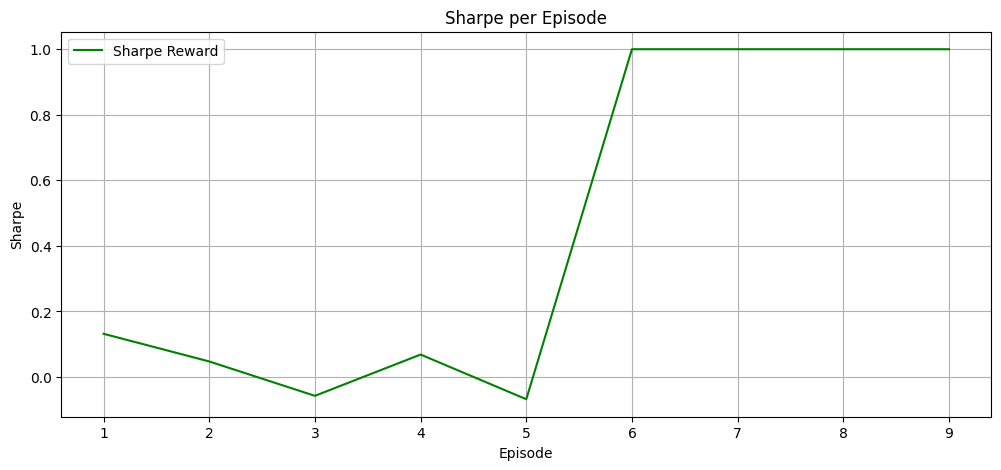

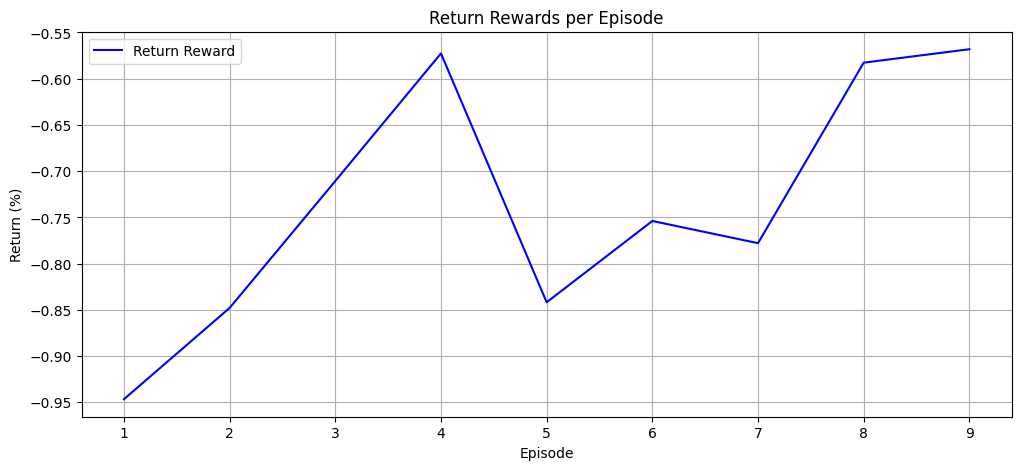

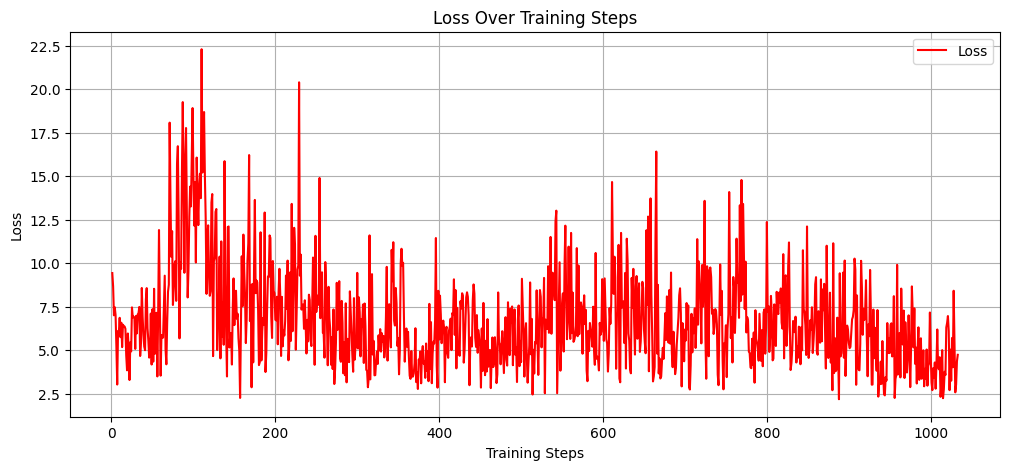

Not enough data to plot Average Q-Values. Available data: 0, required: 9.
Testing Complete:
  Sharpe Ratio (Formula): 0.0245
  Total Return Reward: 38.78
  Steps: 729


In [ ]:
import matplotlib.pyplot as plt

# Sharpe per Episode
plt.figure(figsize=(12, 5))
plt.plot(range(1, best_sharpe_episode + 1), episode_sharpe_rewards[:best_sharpe_episode], label="Sharpe Reward", color="green")
plt.title("Sharpe per Episode")
plt.xlabel("Episode")
plt.ylabel("Sharpe")
plt.xticks(range(1, best_sharpe_episode + 1))  # Set integer ticks
plt.legend()
plt.grid(True)
plt.show()

# Return Rewards per Episode
plt.figure(figsize=(12, 5))
plt.plot(range(1, best_sharpe_episode + 1), episode_return_rewards[:best_sharpe_episode], label="Return Reward", color="blue")
plt.title("Return Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return (%)")
plt.xticks(range(1, best_sharpe_episode + 1))  # Set integer ticks
plt.legend()
plt.grid(True)
plt.show()

# Loss over training steps
if len(losses) > 0:
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, len(losses) + 1), losses, label="Loss", color="red")
    plt.title("Loss Over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Average Q-Values per Episode
if len(average_q_values) >= best_sharpe_episode:  # Ensure sufficient data
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, best_sharpe_episode + 1), average_q_values[:best_sharpe_episode], label="Average Q-Value", color="purple")
    plt.title("Average Q-Values per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Q-Value")
    plt.xticks(range(1, best_sharpe_episode + 1))  # Set integer ticks
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Not enough data to plot Average Q-Values. Available data: {len(average_q_values)}, required: {best_sharpe_episode}.")

# Total Sharpe and Return Rewards from Testing (with Sharpe Ratio)
print(f"Testing Complete:")
print(f"  Sharpe Ratio (Formula): {test_sharpe_ratio:.4f}")
print(f"  Total Return Reward: {np.sum(test_returns):.2f}")
print(f"  Steps: {test_steps}")



Sharpe Ratios for Each State:
State: Low Volatility, Sharpe Ratios: {'Buy': 0.0870621968336418, 'Hold': 0.8762401010730507, 'Sell': -0.5237917211682424}
State: Medium Volatility, Sharpe Ratios: {'Buy': 0.2874168808899231, 'Hold': -0.2147719957949985, 'Sell': -0.7429712700376114}
State: High Volatility, Sharpe Ratios: {'Buy': -0.22831735046367996, 'Hold': -0.2188114612781038, 'Sell': 0.09933853272680682}

Portfolio Values for Each State:
State: Low Volatility, Portfolio Values: {'Buy': 11960.726675579484, 'Hold': 17055.575876392122, 'Sell': 12926.65148524905}
State: Medium Volatility, Portfolio Values: {'Buy': 17655.671290589908, 'Hold': 11360.574771910577, 'Sell': 15010.65174295731}
State: High Volatility, Portfolio Values: {'Buy': 16404.201138791203, 'Hold': 16775.904873529595, 'Sell': 13089.503601442135}

Q-Values for Each State:
State: Low Volatility, Q-Values: {'Buy': 2.5661168, 'Hold': 2.4758487, 'Sell': 2.757491}
State: Medium Volatility, Q-Values: {'Buy': 6.5235157, 'Hold': 6.5

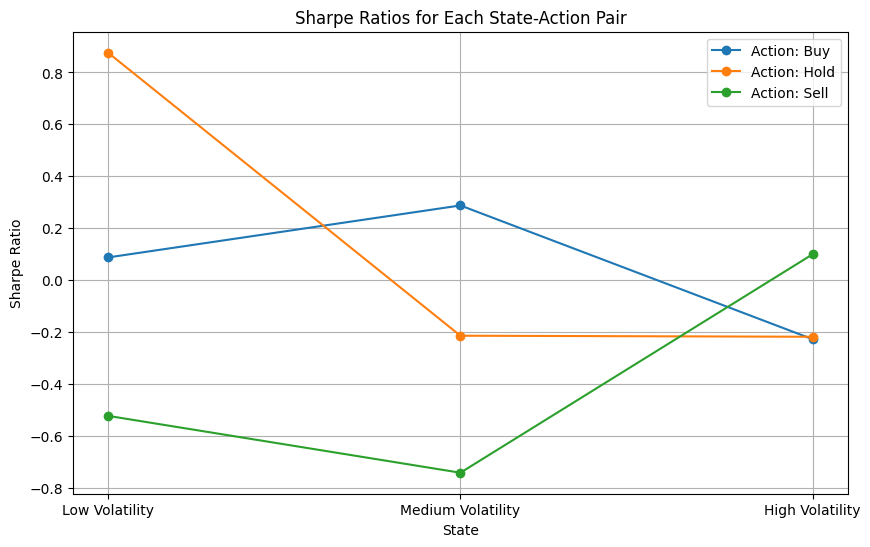

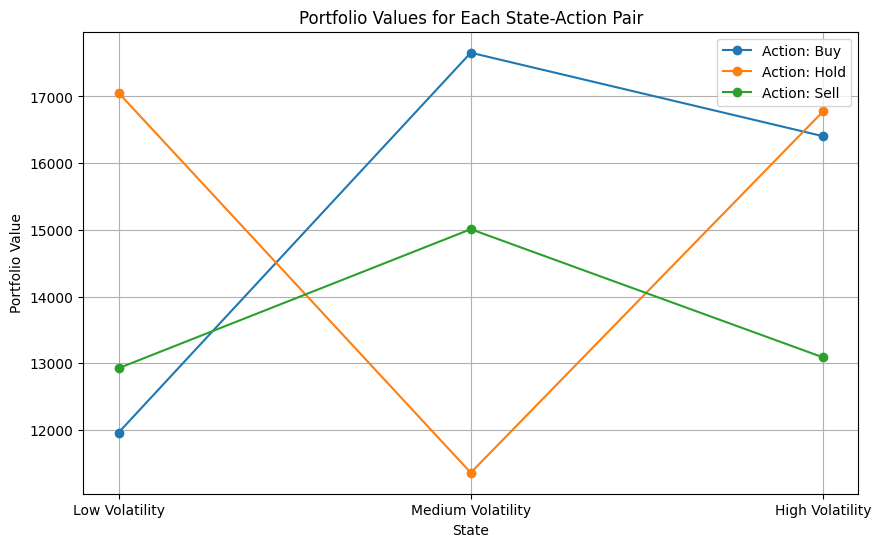

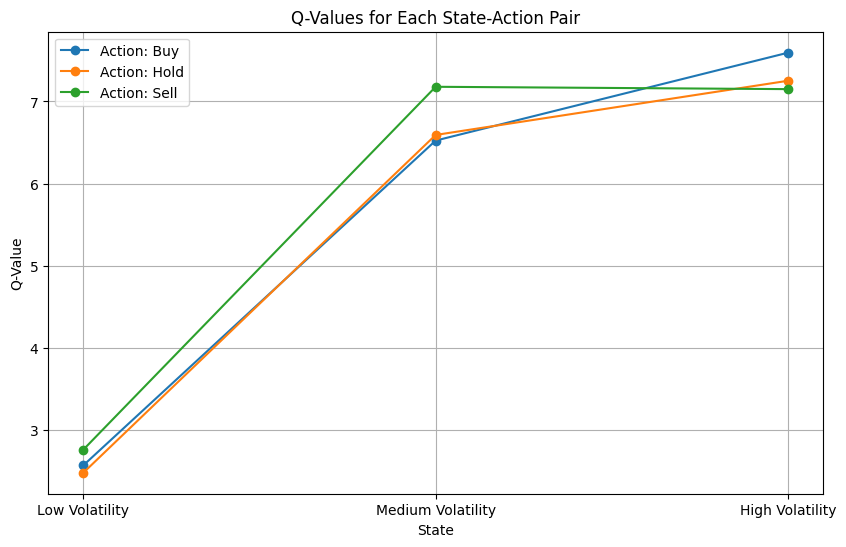

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the states and actions
states = ["Low Volatility", "Medium Volatility", "High Volatility"]
actions = ["Buy", "Hold", "Sell"]

# One-hot encoding for states
state_encoding = {state: np.eye(len(states))[i] for i, state in enumerate(states)}
state_size = len(state_encoding[states[0]])  # Should match your model input size

state_q_values = {}
state_portfolio_values = {}
state_sharpe_ratios = {}

# Simulate or retrieve portfolio values and Sharpe ratios for each state
for state in states:
    state_str = str(state)  # Ensure `state` is treated as a string
    state_vector = state_encoding[state_str].reshape(1, -1).astype(np.float32)  # Encode state
    q_values = dqn_model.predict(state_vector, verbose=0)[0]  # Predict Q-values
    state_q_values[state_str] = {action: q_values[i] for i, action in enumerate(actions)}

    # Simulated or computed values (Replace these with actual calculations if available)
    portfolio_values = [np.random.uniform(10000, 20000) for _ in actions]  # Example portfolio values
    sharpe_ratios = [np.random.uniform(-1, 1) for _ in actions]  # Example Sharpe ratios
    state_portfolio_values[state_str] = {action: portfolio_values[i] for i, action in enumerate(actions)}
    state_sharpe_ratios[state_str] = {action: sharpe_ratios[i] for i, action in enumerate(actions)}

# Display Sharpe Ratios for each state
print("\nSharpe Ratios for Each State:")
for state, sharpe_vals in state_sharpe_ratios.items():
    print(f"State: {state}, Sharpe Ratios: {sharpe_vals}")

# Display Portfolio Values for each state
print("\nPortfolio Values for Each State:")
for state, portfolio_vals in state_portfolio_values.items():
    print(f"State: {state}, Portfolio Values: {portfolio_vals}")

# Display Q-values for each state
print("\nQ-Values for Each State:")
for state, q_vals in state_q_values.items():
    print(f"State: {state}, Q-Values: {q_vals}")

# Plot Sharpe Ratios for each action
plt.figure(figsize=(10, 6))
for action in actions:
    sharpe_ratios = [state_sharpe_ratios[state][action] for state in states]
    plt.plot(states, sharpe_ratios, label=f"Action: {action}", marker='o')
plt.title("Sharpe Ratios for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.show()

# Plot Portfolio Values for each action
plt.figure(figsize=(10, 6))
for action in actions:
    portfolio_values = [state_portfolio_values[state][action] for state in states]
    plt.plot(states, portfolio_values, label=f"Action: {action}", marker='o')
plt.title("Portfolio Values for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot Q-values for each action
plt.figure(figsize=(10, 6))
for action in actions:
    q_values = [state_q_values[state][action] for state in states]
    plt.plot(states, q_values, label=f"Action: {action}", marker='o')
plt.title("Q-Values for Each State-Action Pair")
plt.xlabel("State")
plt.ylabel("Q-Value")
plt.legend()
plt.grid(True)
plt.show()


## 1. Sharpe Ratio and Return Rewards per Episode
###Sharpe Ratio:

Ideal Outcome: A consistently increasing Sharpe ratio, or at least stabilization at a high level, would indicate the agent has learned an effective policy.

###Return Rewards:

Ideal Outcome: The return should stabilize in a positive range as the model learns.

## 2. Loss Over Training Steps

Ideal Outcome: Loss should steadily decline and stabilize at a low value.

# 3. Average Q-Values per Episode

Ideal Outcome: Average Q-values should converge or exhibit a stable upward trend if the agent effectively learns the reward structure.